In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords

from keras.models import Sequential
from keras.layers import Embedding, Dense, LSTM, Dropout
from keras.layers.wrappers import Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models.keyedvectors import KeyedVectors

from sklearn.metrics import classification_report, confusion_matrix, f1_score

import tensorflow as tf
import math
import warnings

In [2]:
train_df_master = pd.read_csv('Combined_Train_data_cleaned.csv')
test_df_master = pd.read_csv('Test_data_cleaned.csv')

In [3]:
train_df = train_df_master.copy()
print('Training data has {} rows and {} columns'.format(train_df.shape[0], train_df.shape[1]))

test_df = test_df_master.copy()
print('Testing data has {} rows and {} columns'.format(test_df.shape[0], test_df.shape[1]))

Training data has 14215 rows and 2 columns
Testing data has 1387 rows and 1 columns


In [4]:
# define the training and testing lengths to keep a track on encoded data
train_length = len(train_df)
test_length = len(test_df)

### Functions for building the data for LSTM model

In [5]:
""" Although the data in this file is already cleaned, we still perform a double check """

def tokenize(text):
    stop_words = stopwords.words('english')    
    
    tokenized_text = []
    
    for txt in text:
        words = txt.split(' ')
        tokenized_string = ''

        for word in words:
            # check for name handles and unwanted text
            if word[0] != '@' and word not in stop_words:
                # if the word is a hastag, remove #
                if word[0] == '#':
                    word = word[1:]

                tokenized_string += word + ' '

        tokenized_text.append(tokenized_string)
    
    return tokenized_text

In [6]:
""" encode text -> translate text to a sequence of numbers """

def encode_text(text):
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=" ", lower=True)
    tokenizer.fit_on_texts(text)
    
    return tokenizer, tokenizer.texts_to_sequences(text)

In [7]:
""" Apply padding to dataset and convert labels (-1, 0, 1) to bitmaps """

def format_data(encoded_text, max_length, sent_labels):
    x = pad_sequences(encoded_text, maxlen= max_length, padding='post')
    y = []
    
    for label in sent_labels:
        bit_vec = np.zeros(3)
        bit_vec[label+1] = 1
        y.append(bit_vec)
        
    y = np.asarray(y)
    return x, y

In [8]:
""" create weight matrix from pre trained embeddings """

def create_weight_matrix(vocab, raw_embeddings):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, 300))
    
    for word, idx in vocab.items():
        if word in raw_embeddings:
            weight_matrix[idx] = raw_embeddings[word]
    
    return weight_matrix

In [9]:
""" Define f1 score to be passed as metric for model evaluation """



' Define f1 score to be passed as metric for model evaluation '

### Defining the model

In [36]:
""" final model """
def final_model(weight_matrix, vocab_size, max_length):
    embedding_layer = Embedding(vocab_size, 300, weights=[weight_matrix], input_length=max_length, trainable=True, 
                                mask_zero=True)
    model = Sequential()
    model.add(embedding_layer)
    
    model.add(Bidirectional(LSTM(300, dropout = 0.2, return_sequences=True)))
    model.add(Dense(256))
    model.add(Bidirectional(LSTM(300, dropout = 0.2)))
    model.add(Dense(256))
    model.add(Dropout(0.3))
    
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

### Preparing Data

In [12]:
""" Tokenize all the training and testing text """

tokenized_text = tokenize(train_df['text'])
tokenized_text += tokenize(test_df['text'])

max_length = math.ceil(sum([len(s.split(" ")) for s in tokenized_text])/len(tokenized_text))

tokenizer, encoded_text = encode_text(tokenized_text)

max_length, len(tokenized_text)

(14, 15602)

In [13]:
""" Apply padding and format data """

x, y = format_data(encoded_text[:train_length], max_length, train_df['sentiment_class'])
print('For train data: ', len(x), len(y))

x_test = pad_sequences(encoded_text[train_length:], maxlen= max_length, padding='post')
print('For test data: ', len(x_test))

For train data:  14215 14215
For test data:  1387


In [14]:
""" Clearing vocabulary """

vocab = tokenizer.word_index
vocab, len(vocab)

({'day': 1,
  'happy': 2,
  'mothers': 3,
  'united': 4,
  'flight': 5,
  'mothersday': 6,
  'mother': 7,
  'usairways': 8,
  'americanair': 9,
  'southwestair': 10,
  'jetblue': 11,
  'love': 12,
  'mum': 13,
  'get': 14,
  'today': 15,
  'mums': 16,
  'thanks': 17,
  'co': 18,
  'http': 19,
  'thank': 20,
  'time': 21,
  'cancelled': 22,
  'would': 23,
  'one': 24,
  'service': 25,
  'help': 26,
  'still': 27,
  'like': 28,
  'know': 29,
  'customer': 30,
  'amazing': 31,
  'cannot': 32,
  'hope': 33,
  'please': 34,
  'hours': 35,
  'call': 36,
  'hold': 37,
  'back': 38,
  'best': 39,
  'need': 40,
  'much': 41,
  'flights': 42,
  'plane': 43,
  'see': 44,
  'great': 45,
  'got': 46,
  'home': 47,
  'happymothersday': 48,
  'world': 49,
  'could': 50,
  'gate': 51,
  'delayed': 52,
  'bag': 53,
  'hour': 54,
  'wonderful': 55,
  'make': 56,
  'virginamerica': 57,
  'flightled': 58,
  'good': 59,
  'family': 60,
  'late': 61,
  'even': 62,
  'always': 63,
  'never': 64,
  'everyone'

In [15]:
# """ Load w2v raw embeddings """

# raw_embeddings = KeyedVectors.load_word2vec_format('model_swm_300-6-10-low.w2v', binary=False)
# raw_embeddings

C:\Users\hp\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [16]:
""" Create the weight matrix """

weight_matrix = create_weight_matrix(vocab, raw_embeddings)
len(weight_matrix)

27728

In [ ]:
# # load the GloVe vectors in a dictionary:

# embeddings_index = {}
# f = open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt','r',encoding='utf-8')
# for line in tqdm(f):
#     values = line.split(' ')
#     word = values[0]
#     coefs = np.asarray([float(val) for val in values[1:]])
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))

### Start training the model

In [37]:
model = final_model(weight_matrix, len(vocab)+1, max_length)

history = model.fit(x, y, epochs = 20, validation_split = 0.1, verbose = 1)

Train on 12793 samples, validate on 1422 samples
Epoch 1/20


 6496/12793 [==============>...............] - ETA: 45:54 - loss: 1.0893 - acc: 0.34 - ETA: 24:52 - loss: 1.1462 - acc: 0.37 - ETA: 17:52 - loss: 1.0903 - acc: 0.42 - ETA: 14:20 - loss: 1.0800 - acc: 0.42 - ETA: 12:46 - loss: 1.0443 - acc: 0.45 - ETA: 11:32 - loss: 1.0132 - acc: 0.48 - ETA: 10:25 - loss: 1.0197 - acc: 0.50 - ETA: 9:38 - loss: 0.9795 - acc: 0.5312 - ETA: 9:17 - loss: 0.9599 - acc: 0.552 - ETA: 8:52 - loss: 0.9544 - acc: 0.562 - ETA: 8:24 - loss: 0.9300 - acc: 0.573 - ETA: 8:02 - loss: 0.9121 - acc: 0.591 - ETA: 7:55 - loss: 0.9198 - acc: 0.596 - ETA: 7:43 - loss: 0.9153 - acc: 0.600 - ETA: 7:28 - loss: 0.9275 - acc: 0.602 - ETA: 7:14 - loss: 0.9199 - acc: 0.607 - ETA: 7:01 - loss: 0.9006 - acc: 0.617 - ETA: 6:50 - loss: 0.9112 - acc: 0.614 - ETA: 6:49 - loss: 0.9079 - acc: 0.620 - ETA: 6:43 - loss: 0.9070 - acc: 0.614 - ETA: 6:33 - loss: 0.9081 - acc: 0.614 - ETA: 6:25 - loss: 0.9051 - acc: 0.616 - ETA: 6:25 - loss: 0.8908 - acc: 0.625 - ETA: 6:21 - loss: 0.8841 - acc: 

12793/12793 [==============================] - ETA: 2:36 - loss: 0.7319 - acc: 0.688 - ETA: 2:35 - loss: 0.7311 - acc: 0.688 - ETA: 2:34 - loss: 0.7318 - acc: 0.688 - ETA: 2:33 - loss: 0.7318 - acc: 0.688 - ETA: 2:32 - loss: 0.7320 - acc: 0.689 - ETA: 2:31 - loss: 0.7314 - acc: 0.689 - ETA: 2:31 - loss: 0.7307 - acc: 0.689 - ETA: 2:30 - loss: 0.7313 - acc: 0.689 - ETA: 2:29 - loss: 0.7314 - acc: 0.689 - ETA: 2:28 - loss: 0.7311 - acc: 0.689 - ETA: 2:27 - loss: 0.7303 - acc: 0.690 - ETA: 2:27 - loss: 0.7296 - acc: 0.690 - ETA: 2:26 - loss: 0.7305 - acc: 0.690 - ETA: 2:25 - loss: 0.7304 - acc: 0.690 - ETA: 2:24 - loss: 0.7309 - acc: 0.690 - ETA: 2:23 - loss: 0.7300 - acc: 0.690 - ETA: 2:22 - loss: 0.7296 - acc: 0.690 - ETA: 2:21 - loss: 0.7298 - acc: 0.690 - ETA: 2:21 - loss: 0.7288 - acc: 0.690 - ETA: 2:20 - loss: 0.7281 - acc: 0.691 - ETA: 2:19 - loss: 0.7277 - acc: 0.691 - ETA: 2:18 - loss: 0.7272 - acc: 0.691 - ETA: 2:18 - loss: 0.7269 - acc: 0.691 - ETA: 2:17 - loss: 0.7264 - acc: 0

 6528/12793 [==============>...............] - ETA: 6:17 - loss: 0.5250 - acc: 0.750 - ETA: 5:11 - loss: 0.5122 - acc: 0.750 - ETA: 4:50 - loss: 0.5065 - acc: 0.781 - ETA: 5:17 - loss: 0.4886 - acc: 0.789 - ETA: 5:18 - loss: 0.5054 - acc: 0.775 - ETA: 5:06 - loss: 0.4844 - acc: 0.791 - ETA: 5:06 - loss: 0.4635 - acc: 0.803 - ETA: 5:18 - loss: 0.4528 - acc: 0.804 - ETA: 5:10 - loss: 0.4845 - acc: 0.784 - ETA: 5:01 - loss: 0.4967 - acc: 0.784 - ETA: 4:59 - loss: 0.5012 - acc: 0.781 - ETA: 5:08 - loss: 0.4884 - acc: 0.791 - ETA: 5:04 - loss: 0.4767 - acc: 0.798 - ETA: 4:59 - loss: 0.4781 - acc: 0.792 - ETA: 4:58 - loss: 0.4676 - acc: 0.800 - ETA: 5:04 - loss: 0.4700 - acc: 0.794 - ETA: 5:00 - loss: 0.4765 - acc: 0.797 - ETA: 4:55 - loss: 0.4697 - acc: 0.800 - ETA: 4:55 - loss: 0.4641 - acc: 0.801 - ETA: 4:58 - loss: 0.4760 - acc: 0.795 - ETA: 4:57 - loss: 0.4777 - acc: 0.794 - ETA: 4:53 - loss: 0.4696 - acc: 0.796 - ETA: 4:56 - loss: 0.4656 - acc: 0.800 - ETA: 4:58 - loss: 0.4713 - acc: 0

12793/12793 [==============================] - ETA: 2:34 - loss: 0.5379 - acc: 0.778 - ETA: 2:33 - loss: 0.5374 - acc: 0.778 - ETA: 2:33 - loss: 0.5380 - acc: 0.778 - ETA: 2:32 - loss: 0.5397 - acc: 0.778 - ETA: 2:31 - loss: 0.5397 - acc: 0.778 - ETA: 2:30 - loss: 0.5401 - acc: 0.778 - ETA: 2:30 - loss: 0.5393 - acc: 0.778 - ETA: 2:29 - loss: 0.5390 - acc: 0.778 - ETA: 2:28 - loss: 0.5388 - acc: 0.778 - ETA: 2:27 - loss: 0.5385 - acc: 0.778 - ETA: 2:26 - loss: 0.5379 - acc: 0.779 - ETA: 2:25 - loss: 0.5376 - acc: 0.779 - ETA: 2:25 - loss: 0.5370 - acc: 0.779 - ETA: 2:24 - loss: 0.5362 - acc: 0.780 - ETA: 2:23 - loss: 0.5365 - acc: 0.780 - ETA: 2:22 - loss: 0.5358 - acc: 0.780 - ETA: 2:21 - loss: 0.5371 - acc: 0.779 - ETA: 2:21 - loss: 0.5369 - acc: 0.779 - ETA: 2:20 - loss: 0.5375 - acc: 0.779 - ETA: 2:19 - loss: 0.5381 - acc: 0.779 - ETA: 2:18 - loss: 0.5388 - acc: 0.778 - ETA: 2:18 - loss: 0.5389 - acc: 0.778 - ETA: 2:17 - loss: 0.5388 - acc: 0.778 - ETA: 2:16 - loss: 0.5378 - acc: 0

 6528/12793 [==============>...............] - ETA: 8:03 - loss: 0.5441 - acc: 0.718 - ETA: 7:19 - loss: 0.5236 - acc: 0.812 - ETA: 6:25 - loss: 0.4626 - acc: 0.843 - ETA: 6:40 - loss: 0.4660 - acc: 0.835 - ETA: 6:36 - loss: 0.4184 - acc: 0.856 - ETA: 6:13 - loss: 0.4234 - acc: 0.843 - ETA: 6:10 - loss: 0.4202 - acc: 0.843 - ETA: 6:20 - loss: 0.4334 - acc: 0.835 - ETA: 6:08 - loss: 0.4395 - acc: 0.826 - ETA: 5:55 - loss: 0.4414 - acc: 0.828 - ETA: 5:58 - loss: 0.4202 - acc: 0.835 - ETA: 5:56 - loss: 0.4069 - acc: 0.841 - ETA: 5:47 - loss: 0.4023 - acc: 0.841 - ETA: 5:42 - loss: 0.4026 - acc: 0.837 - ETA: 5:46 - loss: 0.4039 - acc: 0.837 - ETA: 5:40 - loss: 0.3950 - acc: 0.841 - ETA: 5:35 - loss: 0.3851 - acc: 0.845 - ETA: 5:33 - loss: 0.3918 - acc: 0.845 - ETA: 5:36 - loss: 0.3880 - acc: 0.847 - ETA: 5:30 - loss: 0.4022 - acc: 0.840 - ETA: 5:25 - loss: 0.4024 - acc: 0.839 - ETA: 5:25 - loss: 0.3968 - acc: 0.839 - ETA: 5:27 - loss: 0.3894 - acc: 0.845 - ETA: 5:22 - loss: 0.3830 - acc: 0

12793/12793 [==============================] - ETA: 2:41 - loss: 0.3500 - acc: 0.865 - ETA: 2:40 - loss: 0.3505 - acc: 0.865 - ETA: 2:39 - loss: 0.3515 - acc: 0.864 - ETA: 2:38 - loss: 0.3526 - acc: 0.864 - ETA: 2:37 - loss: 0.3523 - acc: 0.864 - ETA: 2:37 - loss: 0.3524 - acc: 0.864 - ETA: 2:36 - loss: 0.3518 - acc: 0.864 - ETA: 2:35 - loss: 0.3517 - acc: 0.864 - ETA: 2:34 - loss: 0.3512 - acc: 0.864 - ETA: 2:33 - loss: 0.3521 - acc: 0.864 - ETA: 2:33 - loss: 0.3521 - acc: 0.864 - ETA: 2:32 - loss: 0.3516 - acc: 0.864 - ETA: 2:31 - loss: 0.3530 - acc: 0.863 - ETA: 2:30 - loss: 0.3534 - acc: 0.863 - ETA: 2:29 - loss: 0.3543 - acc: 0.862 - ETA: 2:28 - loss: 0.3541 - acc: 0.862 - ETA: 2:27 - loss: 0.3541 - acc: 0.862 - ETA: 2:27 - loss: 0.3537 - acc: 0.862 - ETA: 2:26 - loss: 0.3528 - acc: 0.863 - ETA: 2:25 - loss: 0.3533 - acc: 0.863 - ETA: 2:24 - loss: 0.3542 - acc: 0.862 - ETA: 2:23 - loss: 0.3535 - acc: 0.862 - ETA: 2:22 - loss: 0.3530 - acc: 0.863 - ETA: 2:21 - loss: 0.3527 - acc: 0

 6528/12793 [==============>...............] - ETA: 4:02 - loss: 0.1762 - acc: 0.937 - ETA: 4:08 - loss: 0.1899 - acc: 0.921 - ETA: 4:59 - loss: 0.1771 - acc: 0.927 - ETA: 5:07 - loss: 0.1684 - acc: 0.929 - ETA: 4:58 - loss: 0.1737 - acc: 0.925 - ETA: 4:52 - loss: 0.1803 - acc: 0.921 - ETA: 5:11 - loss: 0.1883 - acc: 0.928 - ETA: 5:08 - loss: 0.1851 - acc: 0.933 - ETA: 5:20 - loss: 0.1860 - acc: 0.934 - ETA: 5:29 - loss: 0.1753 - acc: 0.937 - ETA: 5:25 - loss: 0.1747 - acc: 0.940 - ETA: 5:16 - loss: 0.1787 - acc: 0.937 - ETA: 5:13 - loss: 0.1828 - acc: 0.935 - ETA: 5:18 - loss: 0.1851 - acc: 0.935 - ETA: 5:14 - loss: 0.1910 - acc: 0.933 - ETA: 5:09 - loss: 0.1878 - acc: 0.935 - ETA: 5:07 - loss: 0.1959 - acc: 0.930 - ETA: 5:19 - loss: 0.2077 - acc: 0.925 - ETA: 5:15 - loss: 0.2027 - acc: 0.927 - ETA: 5:16 - loss: 0.1980 - acc: 0.929 - ETA: 5:23 - loss: 0.2016 - acc: 0.928 - ETA: 5:18 - loss: 0.2018 - acc: 0.926 - ETA: 5:14 - loss: 0.1951 - acc: 0.929 - ETA: 5:17 - loss: 0.1936 - acc: 0

12793/12793 [==============================] - ETA: 2:37 - loss: 0.2037 - acc: 0.925 - ETA: 2:36 - loss: 0.2030 - acc: 0.925 - ETA: 2:35 - loss: 0.2024 - acc: 0.925 - ETA: 2:34 - loss: 0.2028 - acc: 0.925 - ETA: 2:33 - loss: 0.2024 - acc: 0.925 - ETA: 2:32 - loss: 0.2024 - acc: 0.925 - ETA: 2:32 - loss: 0.2030 - acc: 0.925 - ETA: 2:31 - loss: 0.2031 - acc: 0.925 - ETA: 2:30 - loss: 0.2030 - acc: 0.925 - ETA: 2:29 - loss: 0.2027 - acc: 0.925 - ETA: 2:28 - loss: 0.2025 - acc: 0.925 - ETA: 2:28 - loss: 0.2025 - acc: 0.925 - ETA: 2:27 - loss: 0.2021 - acc: 0.926 - ETA: 2:26 - loss: 0.2019 - acc: 0.926 - ETA: 2:25 - loss: 0.2013 - acc: 0.926 - ETA: 2:24 - loss: 0.2015 - acc: 0.926 - ETA: 2:23 - loss: 0.2018 - acc: 0.925 - ETA: 2:22 - loss: 0.2018 - acc: 0.925 - ETA: 2:22 - loss: 0.2027 - acc: 0.925 - ETA: 2:21 - loss: 0.2031 - acc: 0.925 - ETA: 2:20 - loss: 0.2026 - acc: 0.925 - ETA: 2:19 - loss: 0.2030 - acc: 0.925 - ETA: 2:19 - loss: 0.2028 - acc: 0.925 - ETA: 2:18 - loss: 0.2026 - acc: 0

 6528/12793 [==============>...............] - ETA: 5:20 - loss: 0.1370 - acc: 0.937 - ETA: 4:56 - loss: 0.1117 - acc: 0.953 - ETA: 5:46 - loss: 0.1062 - acc: 0.947 - ETA: 5:46 - loss: 0.0936 - acc: 0.960 - ETA: 5:30 - loss: 0.1103 - acc: 0.956 - ETA: 5:21 - loss: 0.1213 - acc: 0.953 - ETA: 5:39 - loss: 0.1144 - acc: 0.955 - ETA: 5:32 - loss: 0.1123 - acc: 0.953 - ETA: 5:24 - loss: 0.1045 - acc: 0.958 - ETA: 5:30 - loss: 0.0977 - acc: 0.962 - ETA: 5:35 - loss: 0.0942 - acc: 0.965 - ETA: 5:27 - loss: 0.0904 - acc: 0.966 - ETA: 5:22 - loss: 0.0932 - acc: 0.963 - ETA: 5:28 - loss: 0.0965 - acc: 0.964 - ETA: 5:24 - loss: 0.1033 - acc: 0.962 - ETA: 5:18 - loss: 0.0988 - acc: 0.964 - ETA: 5:14 - loss: 0.0957 - acc: 0.966 - ETA: 5:19 - loss: 0.0942 - acc: 0.968 - ETA: 5:17 - loss: 0.0966 - acc: 0.967 - ETA: 5:13 - loss: 0.1052 - acc: 0.960 - ETA: 5:15 - loss: 0.1210 - acc: 0.959 - ETA: 5:17 - loss: 0.1176 - acc: 0.961 - ETA: 5:13 - loss: 0.1140 - acc: 0.963 - ETA: 5:09 - loss: 0.1113 - acc: 0

12793/12793 [==============================] - ETA: 2:37 - loss: 0.1285 - acc: 0.952 - ETA: 2:36 - loss: 0.1284 - acc: 0.952 - ETA: 2:36 - loss: 0.1290 - acc: 0.952 - ETA: 2:35 - loss: 0.1291 - acc: 0.952 - ETA: 2:34 - loss: 0.1297 - acc: 0.951 - ETA: 2:33 - loss: 0.1296 - acc: 0.951 - ETA: 2:32 - loss: 0.1294 - acc: 0.951 - ETA: 2:31 - loss: 0.1298 - acc: 0.951 - ETA: 2:30 - loss: 0.1297 - acc: 0.951 - ETA: 2:30 - loss: 0.1295 - acc: 0.951 - ETA: 2:29 - loss: 0.1293 - acc: 0.951 - ETA: 2:28 - loss: 0.1301 - acc: 0.951 - ETA: 2:27 - loss: 0.1297 - acc: 0.951 - ETA: 2:27 - loss: 0.1296 - acc: 0.951 - ETA: 2:26 - loss: 0.1294 - acc: 0.951 - ETA: 2:25 - loss: 0.1293 - acc: 0.951 - ETA: 2:24 - loss: 0.1294 - acc: 0.951 - ETA: 2:23 - loss: 0.1295 - acc: 0.951 - ETA: 2:22 - loss: 0.1290 - acc: 0.952 - ETA: 2:21 - loss: 0.1292 - acc: 0.952 - ETA: 2:21 - loss: 0.1289 - acc: 0.952 - ETA: 2:20 - loss: 0.1286 - acc: 0.952 - ETA: 2:19 - loss: 0.1285 - acc: 0.952 - ETA: 2:18 - loss: 0.1285 - acc: 0

 6528/12793 [==============>...............] - ETA: 4:09 - loss: 0.0840 - acc: 0.968 - ETA: 4:22 - loss: 0.0578 - acc: 0.984 - ETA: 5:13 - loss: 0.0882 - acc: 0.979 - ETA: 5:39 - loss: 0.0698 - acc: 0.984 - ETA: 5:45 - loss: 0.1110 - acc: 0.968 - ETA: 6:15 - loss: 0.1017 - acc: 0.974 - ETA: 6:15 - loss: 0.1071 - acc: 0.964 - ETA: 6:18 - loss: 0.1022 - acc: 0.968 - ETA: 6:33 - loss: 0.0968 - acc: 0.968 - ETA: 6:28 - loss: 0.0897 - acc: 0.971 - ETA: 6:23 - loss: 0.0995 - acc: 0.971 - ETA: 6:19 - loss: 0.1034 - acc: 0.968 - ETA: 6:32 - loss: 0.0974 - acc: 0.971 - ETA: 6:27 - loss: 0.0998 - acc: 0.971 - ETA: 6:23 - loss: 0.1012 - acc: 0.968 - ETA: 6:32 - loss: 0.1053 - acc: 0.966 - ETA: 6:28 - loss: 0.1010 - acc: 0.968 - ETA: 6:28 - loss: 0.0982 - acc: 0.968 - ETA: 6:33 - loss: 0.0984 - acc: 0.968 - ETA: 6:29 - loss: 0.0944 - acc: 0.970 - ETA: 6:26 - loss: 0.0946 - acc: 0.970 - ETA: 6:23 - loss: 0.0967 - acc: 0.968 - ETA: 6:28 - loss: 0.1017 - acc: 0.967 - ETA: 6:26 - loss: 0.0977 - acc: 0

12793/12793 [==============================] - ETA: 3:30 - loss: 0.0919 - acc: 0.968 - ETA: 3:30 - loss: 0.0919 - acc: 0.968 - ETA: 3:28 - loss: 0.0916 - acc: 0.968 - ETA: 3:28 - loss: 0.0917 - acc: 0.968 - ETA: 3:26 - loss: 0.0926 - acc: 0.967 - ETA: 3:25 - loss: 0.0925 - acc: 0.967 - ETA: 3:24 - loss: 0.0927 - acc: 0.967 - ETA: 3:23 - loss: 0.0925 - acc: 0.967 - ETA: 3:22 - loss: 0.0928 - acc: 0.967 - ETA: 3:21 - loss: 0.0931 - acc: 0.967 - ETA: 3:20 - loss: 0.0936 - acc: 0.967 - ETA: 3:19 - loss: 0.0933 - acc: 0.967 - ETA: 3:18 - loss: 0.0933 - acc: 0.967 - ETA: 3:17 - loss: 0.0930 - acc: 0.967 - ETA: 3:16 - loss: 0.0929 - acc: 0.967 - ETA: 3:14 - loss: 0.0939 - acc: 0.966 - ETA: 3:14 - loss: 0.0936 - acc: 0.966 - ETA: 3:12 - loss: 0.0933 - acc: 0.967 - ETA: 3:11 - loss: 0.0931 - acc: 0.967 - ETA: 3:10 - loss: 0.0928 - acc: 0.967 - ETA: 3:09 - loss: 0.0928 - acc: 0.967 - ETA: 3:08 - loss: 0.0926 - acc: 0.967 - ETA: 3:07 - loss: 0.0927 - acc: 0.967 - ETA: 3:06 - loss: 0.0925 - acc: 0

 6528/12793 [==============>...............] - ETA: 5:30 - loss: 0.0568 - acc: 1.000 - ETA: 4:46 - loss: 0.0372 - acc: 1.000 - ETA: 4:31 - loss: 0.0364 - acc: 1.000 - ETA: 5:07 - loss: 0.0649 - acc: 0.984 - ETA: 5:13 - loss: 0.0595 - acc: 0.987 - ETA: 5:03 - loss: 0.0575 - acc: 0.989 - ETA: 4:59 - loss: 0.0579 - acc: 0.991 - ETA: 5:12 - loss: 0.0544 - acc: 0.992 - ETA: 5:07 - loss: 0.0562 - acc: 0.989 - ETA: 4:59 - loss: 0.0556 - acc: 0.990 - ETA: 4:57 - loss: 0.0531 - acc: 0.991 - ETA: 5:05 - loss: 0.0551 - acc: 0.989 - ETA: 5:01 - loss: 0.0602 - acc: 0.988 - ETA: 4:57 - loss: 0.0581 - acc: 0.988 - ETA: 4:55 - loss: 0.0580 - acc: 0.987 - ETA: 5:00 - loss: 0.0600 - acc: 0.984 - ETA: 4:57 - loss: 0.0576 - acc: 0.985 - ETA: 4:53 - loss: 0.0599 - acc: 0.984 - ETA: 4:54 - loss: 0.0665 - acc: 0.981 - ETA: 4:59 - loss: 0.0671 - acc: 0.981 - ETA: 4:55 - loss: 0.0643 - acc: 0.982 - ETA: 4:52 - loss: 0.0618 - acc: 0.983 - ETA: 4:53 - loss: 0.0608 - acc: 0.983 - ETA: 4:56 - loss: 0.0610 - acc: 0

12793/12793 [==============================] - ETA: 2:32 - loss: 0.0843 - acc: 0.972 - ETA: 2:31 - loss: 0.0848 - acc: 0.972 - ETA: 2:31 - loss: 0.0845 - acc: 0.972 - ETA: 2:30 - loss: 0.0842 - acc: 0.972 - ETA: 2:29 - loss: 0.0839 - acc: 0.972 - ETA: 2:29 - loss: 0.0840 - acc: 0.972 - ETA: 2:28 - loss: 0.0837 - acc: 0.972 - ETA: 2:27 - loss: 0.0835 - acc: 0.972 - ETA: 2:26 - loss: 0.0835 - acc: 0.972 - ETA: 2:25 - loss: 0.0839 - acc: 0.972 - ETA: 2:24 - loss: 0.0835 - acc: 0.972 - ETA: 2:24 - loss: 0.0836 - acc: 0.972 - ETA: 2:23 - loss: 0.0840 - acc: 0.972 - ETA: 2:22 - loss: 0.0837 - acc: 0.972 - ETA: 2:21 - loss: 0.0838 - acc: 0.972 - ETA: 2:21 - loss: 0.0836 - acc: 0.972 - ETA: 2:20 - loss: 0.0839 - acc: 0.972 - ETA: 2:19 - loss: 0.0837 - acc: 0.972 - ETA: 2:18 - loss: 0.0836 - acc: 0.972 - ETA: 2:18 - loss: 0.0840 - acc: 0.972 - ETA: 2:17 - loss: 0.0838 - acc: 0.972 - ETA: 2:16 - loss: 0.0839 - acc: 0.972 - ETA: 2:16 - loss: 0.0838 - acc: 0.972 - ETA: 2:15 - loss: 0.0836 - acc: 0

 6528/12793 [==============>...............] - ETA: 4:04 - loss: 0.1875 - acc: 0.937 - ETA: 3:59 - loss: 0.1024 - acc: 0.968 - ETA: 4:38 - loss: 0.0699 - acc: 0.979 - ETA: 5:10 - loss: 0.0572 - acc: 0.984 - ETA: 4:55 - loss: 0.0481 - acc: 0.987 - ETA: 4:46 - loss: 0.0489 - acc: 0.984 - ETA: 5:04 - loss: 0.0519 - acc: 0.977 - ETA: 5:08 - loss: 0.0468 - acc: 0.980 - ETA: 4:59 - loss: 0.0425 - acc: 0.982 - ETA: 4:54 - loss: 0.0473 - acc: 0.981 - ETA: 5:03 - loss: 0.0515 - acc: 0.980 - ETA: 5:03 - loss: 0.0634 - acc: 0.979 - ETA: 4:58 - loss: 0.0590 - acc: 0.980 - ETA: 4:55 - loss: 0.0601 - acc: 0.979 - ETA: 5:01 - loss: 0.0585 - acc: 0.981 - ETA: 5:00 - loss: 0.0559 - acc: 0.982 - ETA: 4:55 - loss: 0.0569 - acc: 0.979 - ETA: 4:53 - loss: 0.0612 - acc: 0.975 - ETA: 4:59 - loss: 0.0589 - acc: 0.977 - ETA: 4:56 - loss: 0.0577 - acc: 0.978 - ETA: 4:53 - loss: 0.0562 - acc: 0.979 - ETA: 4:51 - loss: 0.0638 - acc: 0.978 - ETA: 4:54 - loss: 0.0648 - acc: 0.978 - ETA: 4:52 - loss: 0.0640 - acc: 0

12793/12793 [==============================] - ETA: 2:36 - loss: 0.0612 - acc: 0.975 - ETA: 2:35 - loss: 0.0610 - acc: 0.976 - ETA: 2:34 - loss: 0.0617 - acc: 0.975 - ETA: 2:34 - loss: 0.0614 - acc: 0.976 - ETA: 2:33 - loss: 0.0613 - acc: 0.976 - ETA: 2:32 - loss: 0.0610 - acc: 0.976 - ETA: 2:31 - loss: 0.0611 - acc: 0.976 - ETA: 2:30 - loss: 0.0608 - acc: 0.976 - ETA: 2:30 - loss: 0.0613 - acc: 0.976 - ETA: 2:29 - loss: 0.0611 - acc: 0.976 - ETA: 2:28 - loss: 0.0609 - acc: 0.976 - ETA: 2:27 - loss: 0.0608 - acc: 0.976 - ETA: 2:26 - loss: 0.0606 - acc: 0.976 - ETA: 2:25 - loss: 0.0609 - acc: 0.976 - ETA: 2:25 - loss: 0.0607 - acc: 0.976 - ETA: 2:24 - loss: 0.0608 - acc: 0.976 - ETA: 2:23 - loss: 0.0615 - acc: 0.976 - ETA: 2:22 - loss: 0.0613 - acc: 0.976 - ETA: 2:22 - loss: 0.0612 - acc: 0.976 - ETA: 2:21 - loss: 0.0613 - acc: 0.976 - ETA: 2:20 - loss: 0.0612 - acc: 0.976 - ETA: 2:19 - loss: 0.0614 - acc: 0.976 - ETA: 2:18 - loss: 0.0614 - acc: 0.976 - ETA: 2:17 - loss: 0.0613 - acc: 0

 6528/12793 [==============>...............] - ETA: 4:04 - loss: 0.0576 - acc: 0.968 - ETA: 5:30 - loss: 0.0572 - acc: 0.968 - ETA: 5:42 - loss: 0.0404 - acc: 0.979 - ETA: 5:17 - loss: 0.0410 - acc: 0.984 - ETA: 5:08 - loss: 0.0333 - acc: 0.987 - ETA: 5:25 - loss: 0.0292 - acc: 0.989 - ETA: 5:21 - loss: 0.0336 - acc: 0.986 - ETA: 5:10 - loss: 0.0315 - acc: 0.988 - ETA: 5:04 - loss: 0.0334 - acc: 0.989 - ETA: 5:14 - loss: 0.0364 - acc: 0.987 - ETA: 5:12 - loss: 0.0352 - acc: 0.988 - ETA: 5:05 - loss: 0.0439 - acc: 0.981 - ETA: 5:04 - loss: 0.0408 - acc: 0.983 - ETA: 5:11 - loss: 0.0411 - acc: 0.982 - ETA: 5:06 - loss: 0.0422 - acc: 0.983 - ETA: 5:01 - loss: 0.0399 - acc: 0.984 - ETA: 5:04 - loss: 0.0394 - acc: 0.985 - ETA: 5:08 - loss: 0.0426 - acc: 0.984 - ETA: 5:03 - loss: 0.0413 - acc: 0.985 - ETA: 4:59 - loss: 0.0395 - acc: 0.985 - ETA: 5:01 - loss: 0.0473 - acc: 0.982 - ETA: 5:04 - loss: 0.0497 - acc: 0.980 - ETA: 5:00 - loss: 0.0481 - acc: 0.981 - ETA: 4:58 - loss: 0.0463 - acc: 0

12793/12793 [==============================] - ETA: 2:52 - loss: 0.0576 - acc: 0.979 - ETA: 2:51 - loss: 0.0575 - acc: 0.979 - ETA: 2:50 - loss: 0.0572 - acc: 0.979 - ETA: 2:49 - loss: 0.0576 - acc: 0.979 - ETA: 2:49 - loss: 0.0577 - acc: 0.979 - ETA: 2:48 - loss: 0.0580 - acc: 0.979 - ETA: 2:47 - loss: 0.0583 - acc: 0.979 - ETA: 2:46 - loss: 0.0581 - acc: 0.979 - ETA: 2:45 - loss: 0.0585 - acc: 0.979 - ETA: 2:44 - loss: 0.0592 - acc: 0.978 - ETA: 2:43 - loss: 0.0592 - acc: 0.978 - ETA: 2:42 - loss: 0.0598 - acc: 0.978 - ETA: 2:41 - loss: 0.0601 - acc: 0.978 - ETA: 2:41 - loss: 0.0599 - acc: 0.978 - ETA: 2:40 - loss: 0.0600 - acc: 0.978 - ETA: 2:39 - loss: 0.0599 - acc: 0.978 - ETA: 2:39 - loss: 0.0597 - acc: 0.978 - ETA: 2:38 - loss: 0.0594 - acc: 0.978 - ETA: 2:37 - loss: 0.0598 - acc: 0.978 - ETA: 2:36 - loss: 0.0597 - acc: 0.978 - ETA: 2:35 - loss: 0.0598 - acc: 0.978 - ETA: 2:34 - loss: 0.0599 - acc: 0.978 - ETA: 2:34 - loss: 0.0602 - acc: 0.978 - ETA: 2:33 - loss: 0.0610 - acc: 0

 6528/12793 [==============>...............] - ETA: 4:31 - loss: 8.3399e-04 - acc: 1.000 - ETA: 5:45 - loss: 0.0149 - acc: 0.9844    - ETA: 5:38 - loss: 0.0106 - acc: 0.989 - ETA: 5:12 - loss: 0.0085 - acc: 0.992 - ETA: 5:23 - loss: 0.0147 - acc: 0.993 - ETA: 5:43 - loss: 0.0188 - acc: 0.989 - ETA: 5:28 - loss: 0.0163 - acc: 0.991 - ETA: 5:17 - loss: 0.0160 - acc: 0.992 - ETA: 5:20 - loss: 0.0150 - acc: 0.993 - ETA: 5:37 - loss: 0.0137 - acc: 0.993 - ETA: 5:42 - loss: 0.0226 - acc: 0.991 - ETA: 5:40 - loss: 0.0227 - acc: 0.992 - ETA: 5:34 - loss: 0.0238 - acc: 0.992 - ETA: 5:44 - loss: 0.0227 - acc: 0.993 - ETA: 5:48 - loss: 0.0212 - acc: 0.993 - ETA: 5:48 - loss: 0.0199 - acc: 0.994 - ETA: 5:55 - loss: 0.0230 - acc: 0.992 - ETA: 5:49 - loss: 0.0261 - acc: 0.991 - ETA: 5:44 - loss: 0.0280 - acc: 0.990 - ETA: 5:50 - loss: 0.0270 - acc: 0.990 - ETA: 5:47 - loss: 0.0258 - acc: 0.991 - ETA: 5:41 - loss: 0.0248 - acc: 0.991 - ETA: 5:35 - loss: 0.0238 - acc: 0.991 - ETA: 5:36 - loss: 0.0234 

12793/12793 [==============================] - ETA: 2:53 - loss: 0.0413 - acc: 0.986 - ETA: 2:52 - loss: 0.0413 - acc: 0.986 - ETA: 2:51 - loss: 0.0411 - acc: 0.986 - ETA: 2:50 - loss: 0.0410 - acc: 0.986 - ETA: 2:49 - loss: 0.0409 - acc: 0.986 - ETA: 2:48 - loss: 0.0409 - acc: 0.986 - ETA: 2:47 - loss: 0.0408 - acc: 0.986 - ETA: 2:47 - loss: 0.0411 - acc: 0.986 - ETA: 2:46 - loss: 0.0412 - acc: 0.986 - ETA: 2:45 - loss: 0.0411 - acc: 0.986 - ETA: 2:43 - loss: 0.0414 - acc: 0.986 - ETA: 2:43 - loss: 0.0413 - acc: 0.986 - ETA: 2:42 - loss: 0.0420 - acc: 0.986 - ETA: 2:41 - loss: 0.0420 - acc: 0.986 - ETA: 2:40 - loss: 0.0420 - acc: 0.985 - ETA: 2:39 - loss: 0.0420 - acc: 0.985 - ETA: 2:39 - loss: 0.0422 - acc: 0.985 - ETA: 2:37 - loss: 0.0420 - acc: 0.985 - ETA: 2:36 - loss: 0.0423 - acc: 0.985 - ETA: 2:36 - loss: 0.0430 - acc: 0.985 - ETA: 2:35 - loss: 0.0430 - acc: 0.985 - ETA: 2:34 - loss: 0.0428 - acc: 0.985 - ETA: 2:33 - loss: 0.0427 - acc: 0.985 - ETA: 2:32 - loss: 0.0433 - acc: 0

 6528/12793 [==============>...............] - ETA: 6:19 - loss: 0.0051 - acc: 1.000 - ETA: 5:06 - loss: 0.0159 - acc: 1.000 - ETA: 4:47 - loss: 0.0203 - acc: 0.989 - ETA: 5:08 - loss: 0.0153 - acc: 0.992 - ETA: 5:22 - loss: 0.0133 - acc: 0.993 - ETA: 5:05 - loss: 0.0143 - acc: 0.994 - ETA: 4:52 - loss: 0.0128 - acc: 0.995 - ETA: 4:54 - loss: 0.0190 - acc: 0.992 - ETA: 5:03 - loss: 0.0181 - acc: 0.993 - ETA: 4:55 - loss: 0.0241 - acc: 0.990 - ETA: 4:48 - loss: 0.0226 - acc: 0.991 - ETA: 4:48 - loss: 0.0212 - acc: 0.992 - ETA: 4:55 - loss: 0.0203 - acc: 0.992 - ETA: 4:49 - loss: 0.0216 - acc: 0.991 - ETA: 4:44 - loss: 0.0215 - acc: 0.991 - ETA: 4:45 - loss: 0.0210 - acc: 0.992 - ETA: 4:50 - loss: 0.0211 - acc: 0.992 - ETA: 4:47 - loss: 0.0288 - acc: 0.987 - ETA: 4:43 - loss: 0.0273 - acc: 0.988 - ETA: 4:42 - loss: 0.0262 - acc: 0.989 - ETA: 4:45 - loss: 0.0263 - acc: 0.989 - ETA: 4:43 - loss: 0.0252 - acc: 0.990 - ETA: 4:40 - loss: 0.0242 - acc: 0.990 - ETA: 4:38 - loss: 0.0233 - acc: 0

12793/12793 [==============================] - ETA: 2:36 - loss: 0.0409 - acc: 0.986 - ETA: 2:35 - loss: 0.0407 - acc: 0.986 - ETA: 2:34 - loss: 0.0406 - acc: 0.986 - ETA: 2:33 - loss: 0.0404 - acc: 0.986 - ETA: 2:33 - loss: 0.0403 - acc: 0.986 - ETA: 2:32 - loss: 0.0404 - acc: 0.986 - ETA: 2:31 - loss: 0.0403 - acc: 0.986 - ETA: 2:30 - loss: 0.0402 - acc: 0.986 - ETA: 2:29 - loss: 0.0400 - acc: 0.986 - ETA: 2:28 - loss: 0.0400 - acc: 0.986 - ETA: 2:27 - loss: 0.0399 - acc: 0.986 - ETA: 2:27 - loss: 0.0397 - acc: 0.987 - ETA: 2:26 - loss: 0.0395 - acc: 0.987 - ETA: 2:25 - loss: 0.0394 - acc: 0.987 - ETA: 2:24 - loss: 0.0398 - acc: 0.986 - ETA: 2:23 - loss: 0.0397 - acc: 0.986 - ETA: 2:23 - loss: 0.0399 - acc: 0.986 - ETA: 2:22 - loss: 0.0397 - acc: 0.986 - ETA: 2:21 - loss: 0.0400 - acc: 0.986 - ETA: 2:20 - loss: 0.0400 - acc: 0.986 - ETA: 2:20 - loss: 0.0399 - acc: 0.986 - ETA: 2:19 - loss: 0.0397 - acc: 0.987 - ETA: 2:18 - loss: 0.0403 - acc: 0.986 - ETA: 2:17 - loss: 0.0401 - acc: 0

 6528/12793 [==============>...............] - ETA: 7:55 - loss: 0.0183 - acc: 1.000 - ETA: 6:51 - loss: 0.0096 - acc: 1.000 - ETA: 6:28 - loss: 0.0067 - acc: 1.000 - ETA: 6:44 - loss: 0.0072 - acc: 1.000 - ETA: 6:12 - loss: 0.0292 - acc: 0.993 - ETA: 5:47 - loss: 0.0330 - acc: 0.994 - ETA: 5:32 - loss: 0.0337 - acc: 0.991 - ETA: 5:39 - loss: 0.0308 - acc: 0.992 - ETA: 5:35 - loss: 0.0292 - acc: 0.993 - ETA: 5:33 - loss: 0.0265 - acc: 0.993 - ETA: 5:41 - loss: 0.0243 - acc: 0.994 - ETA: 5:52 - loss: 0.0305 - acc: 0.992 - ETA: 5:50 - loss: 0.0390 - acc: 0.990 - ETA: 5:58 - loss: 0.0409 - acc: 0.988 - ETA: 5:52 - loss: 0.0384 - acc: 0.989 - ETA: 5:43 - loss: 0.0558 - acc: 0.986 - ETA: 5:36 - loss: 0.0531 - acc: 0.987 - ETA: 5:38 - loss: 0.0504 - acc: 0.987 - ETA: 5:36 - loss: 0.0479 - acc: 0.988 - ETA: 5:29 - loss: 0.0461 - acc: 0.989 - ETA: 5:24 - loss: 0.0507 - acc: 0.986 - ETA: 5:25 - loss: 0.0492 - acc: 0.987 - ETA: 5:23 - loss: 0.0480 - acc: 0.986 - ETA: 5:19 - loss: 0.0468 - acc: 0

12793/12793 [==============================] - ETA: 2:40 - loss: 0.0343 - acc: 0.989 - ETA: 2:40 - loss: 0.0342 - acc: 0.989 - ETA: 2:39 - loss: 0.0340 - acc: 0.989 - ETA: 2:38 - loss: 0.0339 - acc: 0.989 - ETA: 2:37 - loss: 0.0337 - acc: 0.989 - ETA: 2:36 - loss: 0.0338 - acc: 0.989 - ETA: 2:35 - loss: 0.0336 - acc: 0.989 - ETA: 2:34 - loss: 0.0340 - acc: 0.989 - ETA: 2:34 - loss: 0.0340 - acc: 0.989 - ETA: 2:33 - loss: 0.0341 - acc: 0.989 - ETA: 2:32 - loss: 0.0340 - acc: 0.989 - ETA: 2:31 - loss: 0.0339 - acc: 0.989 - ETA: 2:30 - loss: 0.0338 - acc: 0.989 - ETA: 2:29 - loss: 0.0337 - acc: 0.989 - ETA: 2:28 - loss: 0.0337 - acc: 0.989 - ETA: 2:27 - loss: 0.0341 - acc: 0.989 - ETA: 2:27 - loss: 0.0343 - acc: 0.989 - ETA: 2:26 - loss: 0.0342 - acc: 0.989 - ETA: 2:25 - loss: 0.0345 - acc: 0.988 - ETA: 2:24 - loss: 0.0344 - acc: 0.988 - ETA: 2:23 - loss: 0.0343 - acc: 0.988 - ETA: 2:22 - loss: 0.0343 - acc: 0.988 - ETA: 2:21 - loss: 0.0344 - acc: 0.988 - ETA: 2:21 - loss: 0.0343 - acc: 0

 6528/12793 [==============>...............] - ETA: 3:59 - loss: 0.1027 - acc: 0.968 - ETA: 4:14 - loss: 0.0602 - acc: 0.984 - ETA: 5:05 - loss: 0.0409 - acc: 0.989 - ETA: 5:03 - loss: 0.0359 - acc: 0.992 - ETA: 4:52 - loss: 0.0295 - acc: 0.993 - ETA: 4:56 - loss: 0.0254 - acc: 0.994 - ETA: 5:13 - loss: 0.0258 - acc: 0.995 - ETA: 5:03 - loss: 0.0273 - acc: 0.992 - ETA: 4:56 - loss: 0.0251 - acc: 0.993 - ETA: 4:56 - loss: 0.0232 - acc: 0.993 - ETA: 5:06 - loss: 0.0212 - acc: 0.994 - ETA: 5:01 - loss: 0.0232 - acc: 0.992 - ETA: 4:55 - loss: 0.0241 - acc: 0.990 - ETA: 4:59 - loss: 0.0246 - acc: 0.988 - ETA: 5:04 - loss: 0.0234 - acc: 0.989 - ETA: 4:59 - loss: 0.0237 - acc: 0.988 - ETA: 4:54 - loss: 0.0252 - acc: 0.987 - ETA: 4:58 - loss: 0.0239 - acc: 0.987 - ETA: 5:01 - loss: 0.0240 - acc: 0.988 - ETA: 4:57 - loss: 0.0251 - acc: 0.987 - ETA: 4:53 - loss: 0.0258 - acc: 0.988 - ETA: 4:58 - loss: 0.0256 - acc: 0.988 - ETA: 4:57 - loss: 0.0247 - acc: 0.989 - ETA: 4:54 - loss: 0.0239 - acc: 0

12793/12793 [==============================] - ETA: 2:33 - loss: 0.0369 - acc: 0.986 - ETA: 2:33 - loss: 0.0369 - acc: 0.986 - ETA: 2:32 - loss: 0.0368 - acc: 0.986 - ETA: 2:31 - loss: 0.0367 - acc: 0.986 - ETA: 2:30 - loss: 0.0367 - acc: 0.986 - ETA: 2:30 - loss: 0.0365 - acc: 0.986 - ETA: 2:29 - loss: 0.0364 - acc: 0.986 - ETA: 2:28 - loss: 0.0362 - acc: 0.986 - ETA: 2:27 - loss: 0.0365 - acc: 0.986 - ETA: 2:27 - loss: 0.0365 - acc: 0.986 - ETA: 2:26 - loss: 0.0364 - acc: 0.986 - ETA: 2:25 - loss: 0.0367 - acc: 0.986 - ETA: 2:24 - loss: 0.0366 - acc: 0.986 - ETA: 2:23 - loss: 0.0366 - acc: 0.986 - ETA: 2:22 - loss: 0.0364 - acc: 0.986 - ETA: 2:22 - loss: 0.0363 - acc: 0.986 - ETA: 2:21 - loss: 0.0362 - acc: 0.986 - ETA: 2:20 - loss: 0.0362 - acc: 0.986 - ETA: 2:19 - loss: 0.0365 - acc: 0.986 - ETA: 2:18 - loss: 0.0364 - acc: 0.986 - ETA: 2:18 - loss: 0.0362 - acc: 0.986 - ETA: 2:17 - loss: 0.0363 - acc: 0.986 - ETA: 2:16 - loss: 0.0363 - acc: 0.986 - ETA: 2:15 - loss: 0.0362 - acc: 0

 6528/12793 [==============>...............] - ETA: 6:00 - loss: 0.0023 - acc: 1.000 - ETA: 7:16 - loss: 0.0026 - acc: 1.000 - ETA: 6:10 - loss: 0.0081 - acc: 1.000 - ETA: 5:38 - loss: 0.0070 - acc: 1.000 - ETA: 6:12 - loss: 0.0111 - acc: 0.993 - ETA: 6:00 - loss: 0.0138 - acc: 0.994 - ETA: 5:42 - loss: 0.0366 - acc: 0.986 - ETA: 5:59 - loss: 0.0324 - acc: 0.988 - ETA: 6:09 - loss: 0.0341 - acc: 0.986 - ETA: 6:09 - loss: 0.0383 - acc: 0.984 - ETA: 6:18 - loss: 0.0361 - acc: 0.985 - ETA: 6:14 - loss: 0.0345 - acc: 0.987 - ETA: 6:09 - loss: 0.0328 - acc: 0.988 - ETA: 6:14 - loss: 0.0323 - acc: 0.988 - ETA: 6:12 - loss: 0.0387 - acc: 0.985 - ETA: 6:03 - loss: 0.0365 - acc: 0.986 - ETA: 5:58 - loss: 0.0347 - acc: 0.987 - ETA: 6:02 - loss: 0.0332 - acc: 0.987 - ETA: 6:07 - loss: 0.0324 - acc: 0.988 - ETA: 6:02 - loss: 0.0312 - acc: 0.989 - ETA: 5:56 - loss: 0.0332 - acc: 0.988 - ETA: 5:54 - loss: 0.0321 - acc: 0.988 - ETA: 5:55 - loss: 0.0307 - acc: 0.989 - ETA: 5:49 - loss: 0.0296 - acc: 0

12793/12793 [==============================] - ETA: 2:53 - loss: 0.0284 - acc: 0.989 - ETA: 2:52 - loss: 0.0284 - acc: 0.989 - ETA: 2:51 - loss: 0.0287 - acc: 0.989 - ETA: 2:50 - loss: 0.0287 - acc: 0.989 - ETA: 2:49 - loss: 0.0298 - acc: 0.989 - ETA: 2:48 - loss: 0.0302 - acc: 0.989 - ETA: 2:47 - loss: 0.0302 - acc: 0.989 - ETA: 2:46 - loss: 0.0304 - acc: 0.989 - ETA: 2:45 - loss: 0.0303 - acc: 0.989 - ETA: 2:44 - loss: 0.0302 - acc: 0.989 - ETA: 2:43 - loss: 0.0302 - acc: 0.989 - ETA: 2:42 - loss: 0.0302 - acc: 0.989 - ETA: 2:41 - loss: 0.0300 - acc: 0.989 - ETA: 2:41 - loss: 0.0299 - acc: 0.989 - ETA: 2:39 - loss: 0.0298 - acc: 0.989 - ETA: 2:38 - loss: 0.0300 - acc: 0.989 - ETA: 2:37 - loss: 0.0299 - acc: 0.989 - ETA: 2:37 - loss: 0.0298 - acc: 0.989 - ETA: 2:36 - loss: 0.0297 - acc: 0.989 - ETA: 2:34 - loss: 0.0296 - acc: 0.989 - ETA: 2:34 - loss: 0.0301 - acc: 0.989 - ETA: 2:33 - loss: 0.0301 - acc: 0.989 - ETA: 2:32 - loss: 0.0300 - acc: 0.989 - ETA: 2:31 - loss: 0.0300 - acc: 0

 6528/12793 [==============>...............] - ETA: 7:15 - loss: 0.0013 - acc: 1.000 - ETA: 5:53 - loss: 0.0043 - acc: 1.000 - ETA: 5:17 - loss: 0.0034 - acc: 1.000 - ETA: 5:12 - loss: 0.0027 - acc: 1.000 - ETA: 5:40 - loss: 0.0034 - acc: 1.000 - ETA: 5:27 - loss: 0.0081 - acc: 1.000 - ETA: 5:17 - loss: 0.0135 - acc: 0.995 - ETA: 5:33 - loss: 0.0119 - acc: 0.996 - ETA: 5:34 - loss: 0.0164 - acc: 0.993 - ETA: 5:25 - loss: 0.0158 - acc: 0.993 - ETA: 5:21 - loss: 0.0148 - acc: 0.994 - ETA: 5:31 - loss: 0.0139 - acc: 0.994 - ETA: 5:24 - loss: 0.0141 - acc: 0.995 - ETA: 5:18 - loss: 0.0132 - acc: 0.995 - ETA: 5:13 - loss: 0.0125 - acc: 0.995 - ETA: 5:07 - loss: 0.0146 - acc: 0.994 - ETA: 5:07 - loss: 0.0157 - acc: 0.994 - ETA: 5:12 - loss: 0.0163 - acc: 0.994 - ETA: 5:09 - loss: 0.0158 - acc: 0.995 - ETA: 5:04 - loss: 0.0153 - acc: 0.995 - ETA: 5:04 - loss: 0.0247 - acc: 0.992 - ETA: 5:09 - loss: 0.0240 - acc: 0.992 - ETA: 5:05 - loss: 0.0243 - acc: 0.993 - ETA: 5:01 - loss: 0.0234 - acc: 0

12793/12793 [==============================] - ETA: 3:07 - loss: 0.0311 - acc: 0.989 - ETA: 3:06 - loss: 0.0312 - acc: 0.989 - ETA: 3:05 - loss: 0.0313 - acc: 0.989 - ETA: 3:04 - loss: 0.0314 - acc: 0.988 - ETA: 3:03 - loss: 0.0314 - acc: 0.988 - ETA: 3:02 - loss: 0.0312 - acc: 0.989 - ETA: 3:01 - loss: 0.0317 - acc: 0.988 - ETA: 3:00 - loss: 0.0316 - acc: 0.988 - ETA: 2:58 - loss: 0.0318 - acc: 0.988 - ETA: 2:57 - loss: 0.0317 - acc: 0.988 - ETA: 2:56 - loss: 0.0317 - acc: 0.988 - ETA: 2:55 - loss: 0.0316 - acc: 0.988 - ETA: 2:54 - loss: 0.0316 - acc: 0.988 - ETA: 2:53 - loss: 0.0317 - acc: 0.988 - ETA: 2:52 - loss: 0.0315 - acc: 0.988 - ETA: 2:51 - loss: 0.0314 - acc: 0.988 - ETA: 2:50 - loss: 0.0314 - acc: 0.989 - ETA: 2:49 - loss: 0.0315 - acc: 0.988 - ETA: 2:48 - loss: 0.0319 - acc: 0.988 - ETA: 2:47 - loss: 0.0318 - acc: 0.988 - ETA: 2:46 - loss: 0.0317 - acc: 0.988 - ETA: 2:45 - loss: 0.0316 - acc: 0.988 - ETA: 2:44 - loss: 0.0316 - acc: 0.988 - ETA: 2:43 - loss: 0.0317 - acc: 0

 6528/12793 [==============>...............] - ETA: 4:03 - loss: 0.0104 - acc: 1.000 - ETA: 4:29 - loss: 0.0305 - acc: 0.984 - ETA: 5:59 - loss: 0.0268 - acc: 0.989 - ETA: 5:28 - loss: 0.0306 - acc: 0.984 - ETA: 5:21 - loss: 0.0254 - acc: 0.987 - ETA: 5:35 - loss: 0.0231 - acc: 0.989 - ETA: 5:39 - loss: 0.0240 - acc: 0.991 - ETA: 5:33 - loss: 0.0216 - acc: 0.992 - ETA: 5:39 - loss: 0.0200 - acc: 0.993 - ETA: 5:51 - loss: 0.0285 - acc: 0.990 - ETA: 5:45 - loss: 0.0308 - acc: 0.988 - ETA: 5:45 - loss: 0.0290 - acc: 0.989 - ETA: 5:52 - loss: 0.0279 - acc: 0.990 - ETA: 5:44 - loss: 0.0295 - acc: 0.988 - ETA: 5:39 - loss: 0.0282 - acc: 0.989 - ETA: 5:43 - loss: 0.0271 - acc: 0.990 - ETA: 5:41 - loss: 0.0278 - acc: 0.989 - ETA: 5:34 - loss: 0.0309 - acc: 0.987 - ETA: 5:32 - loss: 0.0295 - acc: 0.988 - ETA: 5:35 - loss: 0.0281 - acc: 0.989 - ETA: 5:30 - loss: 0.0290 - acc: 0.988 - ETA: 5:25 - loss: 0.0283 - acc: 0.988 - ETA: 5:23 - loss: 0.0271 - acc: 0.989 - ETA: 5:26 - loss: 0.0261 - acc: 0

12793/12793 [==============================] - ETA: 2:49 - loss: 0.0291 - acc: 0.989 - ETA: 2:48 - loss: 0.0294 - acc: 0.989 - ETA: 2:47 - loss: 0.0292 - acc: 0.989 - ETA: 2:46 - loss: 0.0292 - acc: 0.989 - ETA: 2:45 - loss: 0.0291 - acc: 0.989 - ETA: 2:45 - loss: 0.0291 - acc: 0.989 - ETA: 2:44 - loss: 0.0289 - acc: 0.989 - ETA: 2:43 - loss: 0.0289 - acc: 0.989 - ETA: 2:42 - loss: 0.0293 - acc: 0.989 - ETA: 2:41 - loss: 0.0295 - acc: 0.989 - ETA: 2:40 - loss: 0.0299 - acc: 0.989 - ETA: 2:39 - loss: 0.0300 - acc: 0.989 - ETA: 2:39 - loss: 0.0300 - acc: 0.989 - ETA: 2:38 - loss: 0.0299 - acc: 0.989 - ETA: 2:37 - loss: 0.0297 - acc: 0.989 - ETA: 2:36 - loss: 0.0304 - acc: 0.988 - ETA: 2:35 - loss: 0.0307 - acc: 0.988 - ETA: 2:34 - loss: 0.0306 - acc: 0.988 - ETA: 2:33 - loss: 0.0306 - acc: 0.988 - ETA: 2:33 - loss: 0.0310 - acc: 0.988 - ETA: 2:32 - loss: 0.0311 - acc: 0.988 - ETA: 2:31 - loss: 0.0313 - acc: 0.988 - ETA: 2:30 - loss: 0.0317 - acc: 0.988 - ETA: 2:30 - loss: 0.0317 - acc: 0

 6528/12793 [==============>...............] - ETA: 5:36 - loss: 0.0202 - acc: 1.000 - ETA: 7:06 - loss: 0.0169 - acc: 1.000 - ETA: 6:21 - loss: 0.0290 - acc: 0.989 - ETA: 5:52 - loss: 0.0364 - acc: 0.984 - ETA: 6:08 - loss: 0.0302 - acc: 0.987 - ETA: 6:04 - loss: 0.0306 - acc: 0.989 - ETA: 5:50 - loss: 0.0270 - acc: 0.991 - ETA: 6:23 - loss: 0.0240 - acc: 0.992 - ETA: 6:30 - loss: 0.0299 - acc: 0.989 - ETA: 6:32 - loss: 0.0321 - acc: 0.987 - ETA: 6:25 - loss: 0.0303 - acc: 0.988 - ETA: 6:24 - loss: 0.0279 - acc: 0.989 - ETA: 6:26 - loss: 0.0258 - acc: 0.990 - ETA: 6:29 - loss: 0.0289 - acc: 0.988 - ETA: 6:22 - loss: 0.0270 - acc: 0.989 - ETA: 6:20 - loss: 0.0261 - acc: 0.990 - ETA: 6:26 - loss: 0.0246 - acc: 0.990 - ETA: 6:18 - loss: 0.0234 - acc: 0.991 - ETA: 6:13 - loss: 0.0260 - acc: 0.990 - ETA: 6:17 - loss: 0.0253 - acc: 0.990 - ETA: 6:13 - loss: 0.0254 - acc: 0.991 - ETA: 6:08 - loss: 0.0243 - acc: 0.991 - ETA: 6:08 - loss: 0.0237 - acc: 0.991 - ETA: 6:08 - loss: 0.0248 - acc: 0

12793/12793 [==============================] - ETA: 3:06 - loss: 0.0276 - acc: 0.990 - ETA: 3:05 - loss: 0.0277 - acc: 0.990 - ETA: 3:04 - loss: 0.0276 - acc: 0.990 - ETA: 3:02 - loss: 0.0274 - acc: 0.990 - ETA: 3:02 - loss: 0.0274 - acc: 0.990 - ETA: 3:00 - loss: 0.0279 - acc: 0.990 - ETA: 2:59 - loss: 0.0278 - acc: 0.990 - ETA: 2:58 - loss: 0.0282 - acc: 0.990 - ETA: 2:57 - loss: 0.0283 - acc: 0.990 - ETA: 2:56 - loss: 0.0282 - acc: 0.990 - ETA: 2:55 - loss: 0.0281 - acc: 0.990 - ETA: 2:53 - loss: 0.0279 - acc: 0.990 - ETA: 2:52 - loss: 0.0279 - acc: 0.990 - ETA: 2:51 - loss: 0.0280 - acc: 0.990 - ETA: 2:50 - loss: 0.0279 - acc: 0.990 - ETA: 2:49 - loss: 0.0278 - acc: 0.990 - ETA: 2:48 - loss: 0.0276 - acc: 0.990 - ETA: 2:47 - loss: 0.0276 - acc: 0.990 - ETA: 2:46 - loss: 0.0275 - acc: 0.990 - ETA: 2:44 - loss: 0.0274 - acc: 0.990 - ETA: 2:44 - loss: 0.0273 - acc: 0.990 - ETA: 2:43 - loss: 0.0272 - acc: 0.990 - ETA: 2:41 - loss: 0.0273 - acc: 0.990 - ETA: 2:40 - loss: 0.0272 - acc: 0

 6528/12793 [==============>...............] - ETA: 6:38 - loss: 0.0170 - acc: 1.000 - ETA: 5:30 - loss: 0.0115 - acc: 1.000 - ETA: 5:03 - loss: 0.0089 - acc: 1.000 - ETA: 5:37 - loss: 0.0120 - acc: 1.000 - ETA: 5:40 - loss: 0.0334 - acc: 0.987 - ETA: 5:25 - loss: 0.0280 - acc: 0.989 - ETA: 5:24 - loss: 0.0362 - acc: 0.986 - ETA: 5:36 - loss: 0.0318 - acc: 0.988 - ETA: 5:34 - loss: 0.0300 - acc: 0.989 - ETA: 5:26 - loss: 0.0273 - acc: 0.990 - ETA: 5:34 - loss: 0.0272 - acc: 0.991 - ETA: 5:31 - loss: 0.0397 - acc: 0.989 - ETA: 5:25 - loss: 0.0385 - acc: 0.990 - ETA: 5:22 - loss: 0.0366 - acc: 0.991 - ETA: 5:27 - loss: 0.0348 - acc: 0.991 - ETA: 5:23 - loss: 0.0327 - acc: 0.992 - ETA: 5:18 - loss: 0.0311 - acc: 0.992 - ETA: 5:20 - loss: 0.0301 - acc: 0.993 - ETA: 5:26 - loss: 0.0286 - acc: 0.993 - ETA: 5:21 - loss: 0.0296 - acc: 0.992 - ETA: 5:17 - loss: 0.0293 - acc: 0.992 - ETA: 5:22 - loss: 0.0280 - acc: 0.992 - ETA: 5:20 - loss: 0.0276 - acc: 0.993 - ETA: 5:16 - loss: 0.0271 - acc: 0

12793/12793 [==============================] - ETA: 2:45 - loss: 0.0339 - acc: 0.988 - ETA: 2:44 - loss: 0.0337 - acc: 0.988 - ETA: 2:43 - loss: 0.0336 - acc: 0.988 - ETA: 2:43 - loss: 0.0336 - acc: 0.988 - ETA: 2:42 - loss: 0.0336 - acc: 0.988 - ETA: 2:41 - loss: 0.0341 - acc: 0.988 - ETA: 2:40 - loss: 0.0344 - acc: 0.988 - ETA: 2:39 - loss: 0.0346 - acc: 0.988 - ETA: 2:38 - loss: 0.0349 - acc: 0.987 - ETA: 2:38 - loss: 0.0348 - acc: 0.987 - ETA: 2:37 - loss: 0.0349 - acc: 0.987 - ETA: 2:36 - loss: 0.0351 - acc: 0.987 - ETA: 2:35 - loss: 0.0350 - acc: 0.987 - ETA: 2:35 - loss: 0.0352 - acc: 0.987 - ETA: 2:34 - loss: 0.0351 - acc: 0.987 - ETA: 2:33 - loss: 0.0350 - acc: 0.987 - ETA: 2:32 - loss: 0.0348 - acc: 0.987 - ETA: 2:31 - loss: 0.0358 - acc: 0.987 - ETA: 2:30 - loss: 0.0360 - acc: 0.987 - ETA: 2:29 - loss: 0.0362 - acc: 0.987 - ETA: 2:29 - loss: 0.0360 - acc: 0.987 - ETA: 2:28 - loss: 0.0359 - acc: 0.987 - ETA: 2:27 - loss: 0.0361 - acc: 0.987 - ETA: 2:26 - loss: 0.0359 - acc: 0

 6528/12793 [==============>...............] - ETA: 5:17 - loss: 0.0710 - acc: 0.968 - ETA: 5:51 - loss: 0.0365 - acc: 0.984 - ETA: 5:12 - loss: 0.0251 - acc: 0.989 - ETA: 4:53 - loss: 0.0342 - acc: 0.984 - ETA: 4:55 - loss: 0.0401 - acc: 0.981 - ETA: 5:11 - loss: 0.0375 - acc: 0.984 - ETA: 5:01 - loss: 0.0407 - acc: 0.982 - ETA: 4:51 - loss: 0.0359 - acc: 0.984 - ETA: 4:42 - loss: 0.0348 - acc: 0.986 - ETA: 4:52 - loss: 0.0321 - acc: 0.987 - ETA: 4:55 - loss: 0.0307 - acc: 0.988 - ETA: 4:48 - loss: 0.0282 - acc: 0.989 - ETA: 4:43 - loss: 0.0290 - acc: 0.988 - ETA: 4:48 - loss: 0.0271 - acc: 0.988 - ETA: 4:50 - loss: 0.0258 - acc: 0.989 - ETA: 4:45 - loss: 0.0317 - acc: 0.988 - ETA: 4:42 - loss: 0.0305 - acc: 0.989 - ETA: 4:47 - loss: 0.0352 - acc: 0.986 - ETA: 4:49 - loss: 0.0336 - acc: 0.986 - ETA: 4:45 - loss: 0.0466 - acc: 0.985 - ETA: 4:44 - loss: 0.0474 - acc: 0.983 - ETA: 4:49 - loss: 0.0456 - acc: 0.984 - ETA: 4:47 - loss: 0.0470 - acc: 0.983 - ETA: 4:43 - loss: 0.0456 - acc: 0

12793/12793 [==============================] - ETA: 2:34 - loss: 0.0294 - acc: 0.989 - ETA: 2:33 - loss: 0.0293 - acc: 0.989 - ETA: 2:33 - loss: 0.0296 - acc: 0.989 - ETA: 2:32 - loss: 0.0300 - acc: 0.989 - ETA: 2:31 - loss: 0.0299 - acc: 0.989 - ETA: 2:31 - loss: 0.0299 - acc: 0.989 - ETA: 2:30 - loss: 0.0301 - acc: 0.989 - ETA: 2:29 - loss: 0.0300 - acc: 0.989 - ETA: 2:29 - loss: 0.0299 - acc: 0.989 - ETA: 2:28 - loss: 0.0299 - acc: 0.989 - ETA: 2:27 - loss: 0.0306 - acc: 0.988 - ETA: 2:26 - loss: 0.0305 - acc: 0.988 - ETA: 2:26 - loss: 0.0308 - acc: 0.988 - ETA: 2:25 - loss: 0.0308 - acc: 0.988 - ETA: 2:24 - loss: 0.0308 - acc: 0.988 - ETA: 2:23 - loss: 0.0306 - acc: 0.988 - ETA: 2:22 - loss: 0.0305 - acc: 0.988 - ETA: 2:21 - loss: 0.0304 - acc: 0.988 - ETA: 2:20 - loss: 0.0308 - acc: 0.988 - ETA: 2:20 - loss: 0.0307 - acc: 0.988 - ETA: 2:19 - loss: 0.0305 - acc: 0.988 - ETA: 2:18 - loss: 0.0305 - acc: 0.988 - ETA: 2:17 - loss: 0.0303 - acc: 0.989 - ETA: 2:16 - loss: 0.0303 - acc: 0

 6528/12793 [==============>...............] - ETA: 7:23 - loss: 0.0022 - acc: 1.000 - ETA: 5:42 - loss: 0.0014 - acc: 1.000 - ETA: 5:16 - loss: 0.0026 - acc: 1.000 - ETA: 5:41 - loss: 0.0020 - acc: 1.000 - ETA: 5:45 - loss: 0.0018 - acc: 1.000 - ETA: 5:28 - loss: 0.0017 - acc: 1.000 - ETA: 5:15 - loss: 0.0016 - acc: 1.000 - ETA: 5:26 - loss: 0.0025 - acc: 1.000 - ETA: 5:29 - loss: 0.0036 - acc: 1.000 - ETA: 5:18 - loss: 0.0061 - acc: 1.000 - ETA: 5:13 - loss: 0.0116 - acc: 0.997 - ETA: 5:23 - loss: 0.0186 - acc: 0.994 - ETA: 5:18 - loss: 0.0184 - acc: 0.995 - ETA: 5:14 - loss: 0.0171 - acc: 0.995 - ETA: 5:18 - loss: 0.0162 - acc: 0.995 - ETA: 5:23 - loss: 0.0152 - acc: 0.996 - ETA: 5:19 - loss: 0.0143 - acc: 0.996 - ETA: 5:15 - loss: 0.0188 - acc: 0.994 - ETA: 5:20 - loss: 0.0179 - acc: 0.995 - ETA: 5:18 - loss: 0.0252 - acc: 0.993 - ETA: 5:13 - loss: 0.0240 - acc: 0.994 - ETA: 5:13 - loss: 0.0259 - acc: 0.991 - ETA: 5:15 - loss: 0.0277 - acc: 0.990 - ETA: 5:11 - loss: 0.0270 - acc: 0

12793/12793 [==============================] - ETA: 2:43 - loss: 0.0312 - acc: 0.989 - ETA: 2:42 - loss: 0.0311 - acc: 0.989 - ETA: 2:41 - loss: 0.0309 - acc: 0.989 - ETA: 2:40 - loss: 0.0312 - acc: 0.989 - ETA: 2:39 - loss: 0.0311 - acc: 0.989 - ETA: 2:39 - loss: 0.0313 - acc: 0.989 - ETA: 2:38 - loss: 0.0312 - acc: 0.989 - ETA: 2:37 - loss: 0.0311 - acc: 0.989 - ETA: 2:36 - loss: 0.0321 - acc: 0.989 - ETA: 2:35 - loss: 0.0319 - acc: 0.989 - ETA: 2:34 - loss: 0.0319 - acc: 0.989 - ETA: 2:33 - loss: 0.0321 - acc: 0.989 - ETA: 2:32 - loss: 0.0320 - acc: 0.989 - ETA: 2:32 - loss: 0.0318 - acc: 0.989 - ETA: 2:31 - loss: 0.0317 - acc: 0.989 - ETA: 2:30 - loss: 0.0315 - acc: 0.989 - ETA: 2:30 - loss: 0.0314 - acc: 0.989 - ETA: 2:29 - loss: 0.0317 - acc: 0.989 - ETA: 2:28 - loss: 0.0316 - acc: 0.988 - ETA: 2:27 - loss: 0.0315 - acc: 0.989 - ETA: 2:27 - loss: 0.0314 - acc: 0.989 - ETA: 2:26 - loss: 0.0314 - acc: 0.989 - ETA: 2:25 - loss: 0.0315 - acc: 0.989 - ETA: 2:24 - loss: 0.0313 - acc: 0

In [38]:
model.save('lstm_model_latest.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 14, 300)           8318400   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 14, 600)           1442400   
_________________________________________________________________
dense_11 (Dense)             (None, 14, 256)           153856    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 600)               1336800   
_________________________________________________________________
dense_12 (Dense)             (None, 256)               153856    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 771       
Total para

#### Check model on train data

In [39]:
train_pred_prob = model.predict(x)
train_pred_prob

array([[9.9472791e-01, 4.7324500e-03, 5.3971767e-04],
       [3.7368629e-08, 1.2610555e-07, 9.9999988e-01],
       [1.8419363e-04, 2.5379410e-04, 9.9956197e-01],
       ...,
       [9.3084234e-01, 6.9098465e-02, 5.9090449e-05],
       [6.4097844e-02, 9.3588871e-01, 1.3486483e-05],
       [2.6005067e-04, 9.9969089e-01, 4.9066322e-05]], dtype=float32)

In [40]:
train_pred = [np.argmax(pred)-1 for pred in train_pred_prob]
len(train_pred)

14215

In [41]:
train_f1_score = f1_score(train_df['sentiment_class'], train_pred, average='weighted')

print('F1 Score: ', train_f1_score)
print()
print('Confusion Matrix: \n', confusion_matrix(train_df['sentiment_class'], train_pred))
print()
print('Classification Report: \n', classification_report(train_df['sentiment_class'], train_pred))

F1 Score:  0.9380850563987957

Confusion Matrix: 
 [[7345  229   46]
 [ 145 3729  154]
 [  83  224 2260]]

Classification Report: 
               precision    recall  f1-score   support

          -1       0.97      0.96      0.97      7620
           0       0.89      0.93      0.91      4028
           1       0.92      0.88      0.90      2567

   micro avg       0.94      0.94      0.94     14215
   macro avg       0.93      0.92      0.92     14215
weighted avg       0.94      0.94      0.94     14215



### Predicting Test data

In [42]:
test_pred_prob = model.predict(x_test)
test_pred_prob

array([[9.8816222e-01, 7.4487139e-04, 1.1092950e-02],
       [8.5150678e-09, 1.0000000e+00, 5.0094204e-08],
       [2.6277032e-02, 9.1225827e-01, 6.1464656e-02],
       ...,
       [2.6201454e-04, 9.8331761e-01, 1.6420407e-02],
       [7.8183330e-06, 9.9999213e-01, 3.3965971e-08],
       [5.3095556e-07, 9.9999893e-01, 6.1654157e-07]], dtype=float32)

In [43]:
test_pred = [np.argmax(pred)-1 for pred in test_pred_prob]
len(test_pred)

1387

### Writing the submission

In [44]:
org_test_df = pd.read_csv('Dataset/test.csv')
org_test_df.head()

,id,original_text,lang,retweet_count,original_author
0,1.246628e+18,"3. Yeah, I once cooked potatoes when I was 3 y...",en,0,LToddWood
1,1.245898e+18,"Happy Mother's Day to all the mums, step-mums,...",en,0,iiarushii
2,1.244717e+18,"I love the people from the UK, however, when I...",en,0,andreaanderegg
3,1.245730e+18,Happy 81st Birthday Happy Mother’s Day to my m...,en,1,TheBookTweeters
4,1.244636e+18,Happy Mothers day to all those wonderful mothe...,en,0,andreaanderegg


 0    906
-1    243
 1    238
Name: sentiment_class, dtype: int64


,id,sentiment_class
0,1.246628e+18,-1
1,1.245898e+18,0
2,1.244717e+18,0
3,1.245730e+18,0
4,1.244636e+18,-1


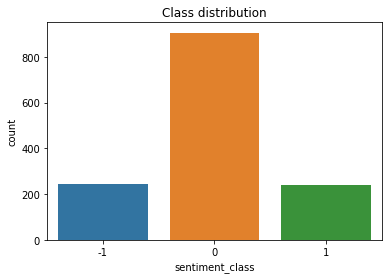

In [46]:
submission_df = org_test_df.copy()
submission_df.drop(['original_text', 'lang', 'retweet_count', 'original_author'], axis = 1, inplace = True)
submission_df['sentiment_class'] = test_pred

print(submission_df['sentiment_class'].value_counts())
sns.countplot(submission_df['sentiment_class']).set_title('Class distribution')
submission_df.to_csv('check for submission local 2.csv', index = False)
submission_df.head()